Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
from statsmodels.stats import multitest

Make Necrosis plots in PC2 vs. PC3 for ccRCC3/4

In [15]:
cancer_code = "ccRCC3"
metabolism_data = pd.read_csv("../Data/Generated Data/Tumor Generated/processed_%s_metabolite_data.csv"%cancer_code)
#metabolism_data = metabolism_data.set_index("Unnamed: 0")
meta_data = pd.read_csv("../Data/Tumour Data/TUMOR.NECROSIS.csv", index_col = "Unnamed: 0")
meta_data.index = [x.replace(".","-") for x in meta_data.index]
list_of_cell_lines = list(set(metabolism_data.index).intersection(set(meta_data.index)))
meta_data = meta_data.loc[list_of_cell_lines]
def NecrosisMapping(necrosisvalue):
    if necrosisvalue != 0:
        return "Exhibits Necrosis"
    else:
        return "Does Not \nExhibit Necrosis"
meta_data["NECROSIS"] = meta_data["NECROSIS"].apply(lambda x: NecrosisMapping(x))

Fit Principal Component Analysis on ccRCC3/4

In [16]:
from sklearn.decomposition import PCA
model = PCA(n_components=10)            # 2. Instantiate the model with hyperparameters
model.fit(metabolism_data)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(metabolism_data)
explained_variance = model.explained_variance_ratio_

Make scatterplot of Necrosis in PC2 vs. PC3

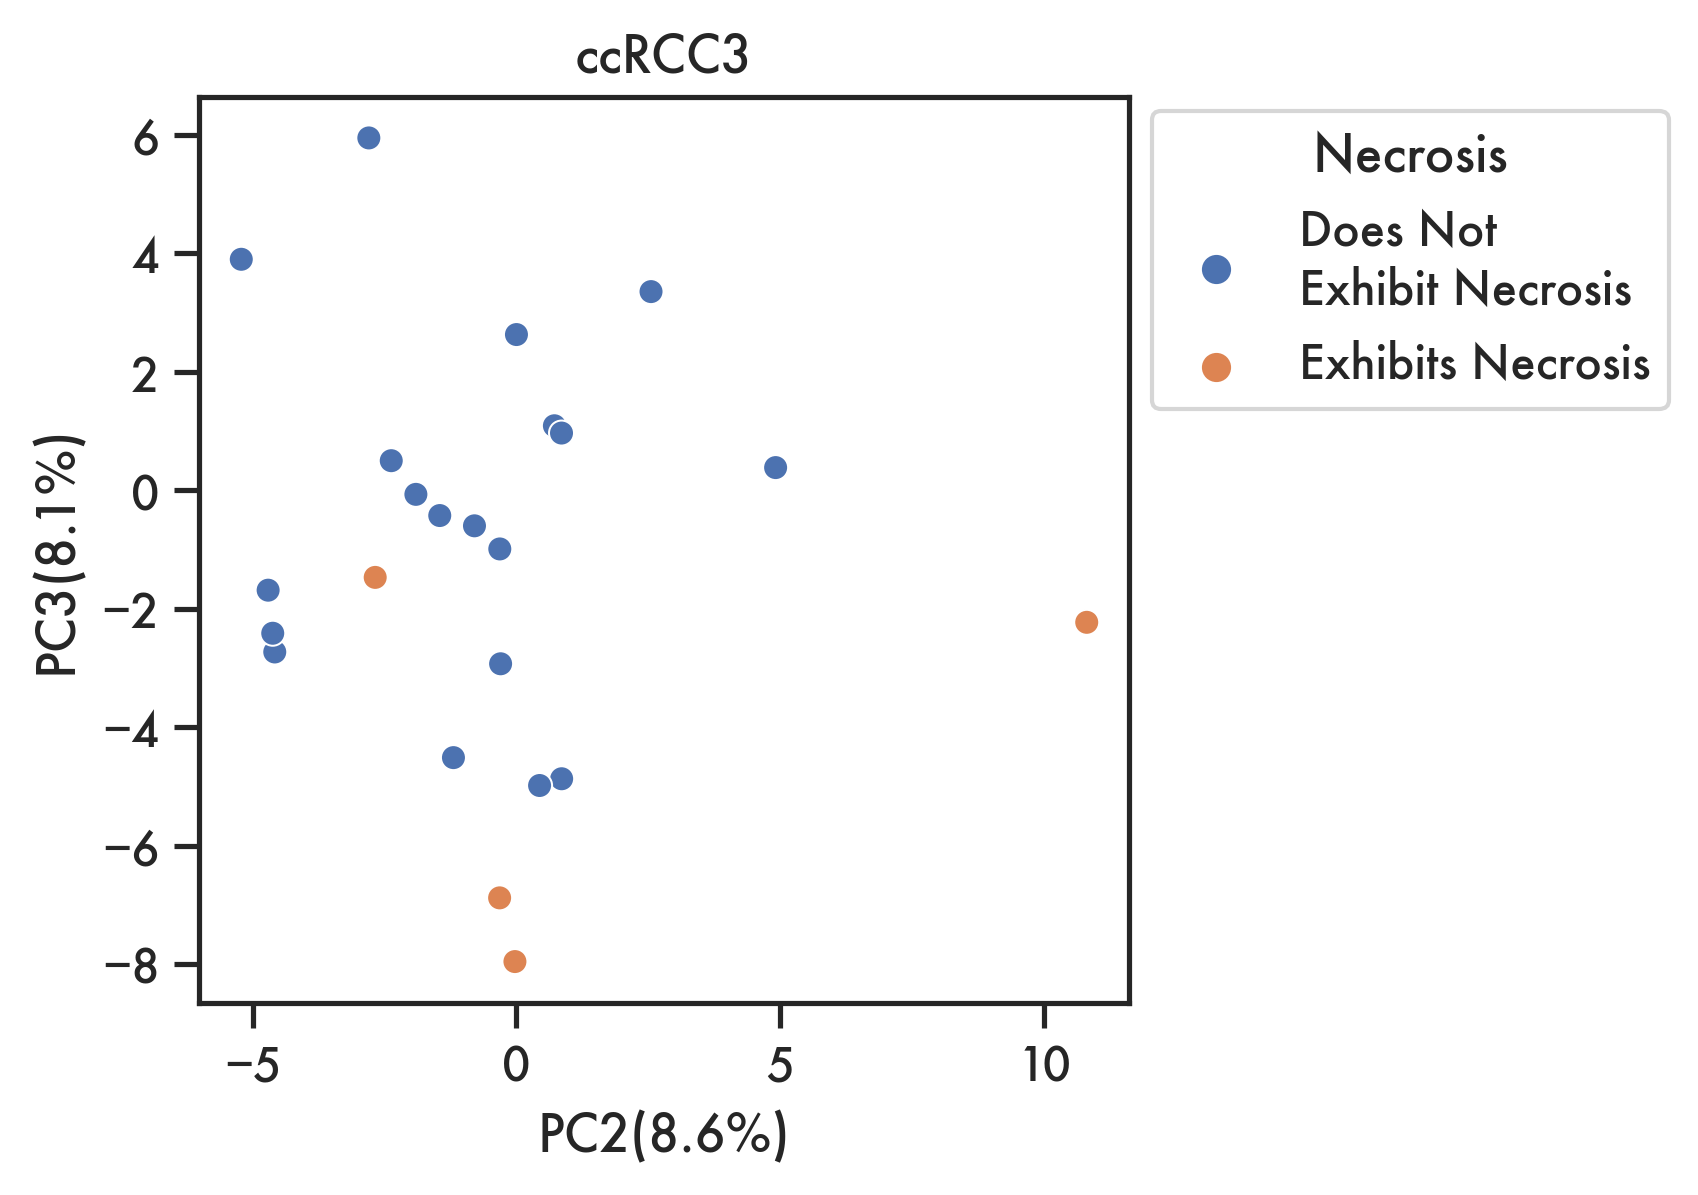

In [17]:
sns.set_theme(style = "ticks", rc={'figure.figsize':(4,4),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
for x in range(0,5):
    metabolism_data["PC"+ str(x+1)] = X_2D[:, x]
metabolism_data = metabolism_data.loc[list_of_cell_lines]
metabolism_data["Necrosis"] = meta_data["NECROSIS"]
fig,axpca = plt.subplots()
first_pc = "PC2"
second_pc = "PC3"
scatter = sns.scatterplot(x = first_pc, y = second_pc, data=metabolism_data, legend = True,hue = "Necrosis", sizes= 1)
scatter.set(title = cancer_code)
axpca.set(xlabel=first_pc+'({}%)'.format(round(explained_variance[1]*100, 1)), ylabel=second_pc+'({}%)'.format(round(explained_variance[2]*100, 1)))
sns.move_legend(axpca,"upper left", bbox_to_anchor=(1, 1.01))

T-test of Necrosis vs Not Exhibiting Necrosis

In [ ]:
matrix = pd.DataFrame(columns = ["F statistic","p-value", "Covariate"])
for i in range(1,6):
    listOflist = []
    print(i)
    for tissue in metabolism_data["Necrosis"].unique():
        listOflist.append(metabolism_data.loc[metabolism_data["Necrosis"] == tissue]["PC%i" %i].values)
    matrix.loc["%i" %i] = (list(scipy.stats.f_oneway(*listOflist))+ ["Necrosis"])
matrix

List necrosis samples for exclusion in downstream analysis

In [25]:
necrosis_samples = 'MSKC-00362', 'MSKC-00334', 'MSKC-00333', 'MSKC-00365'

Plot and calculate effect of Purity across ccRCC3/4

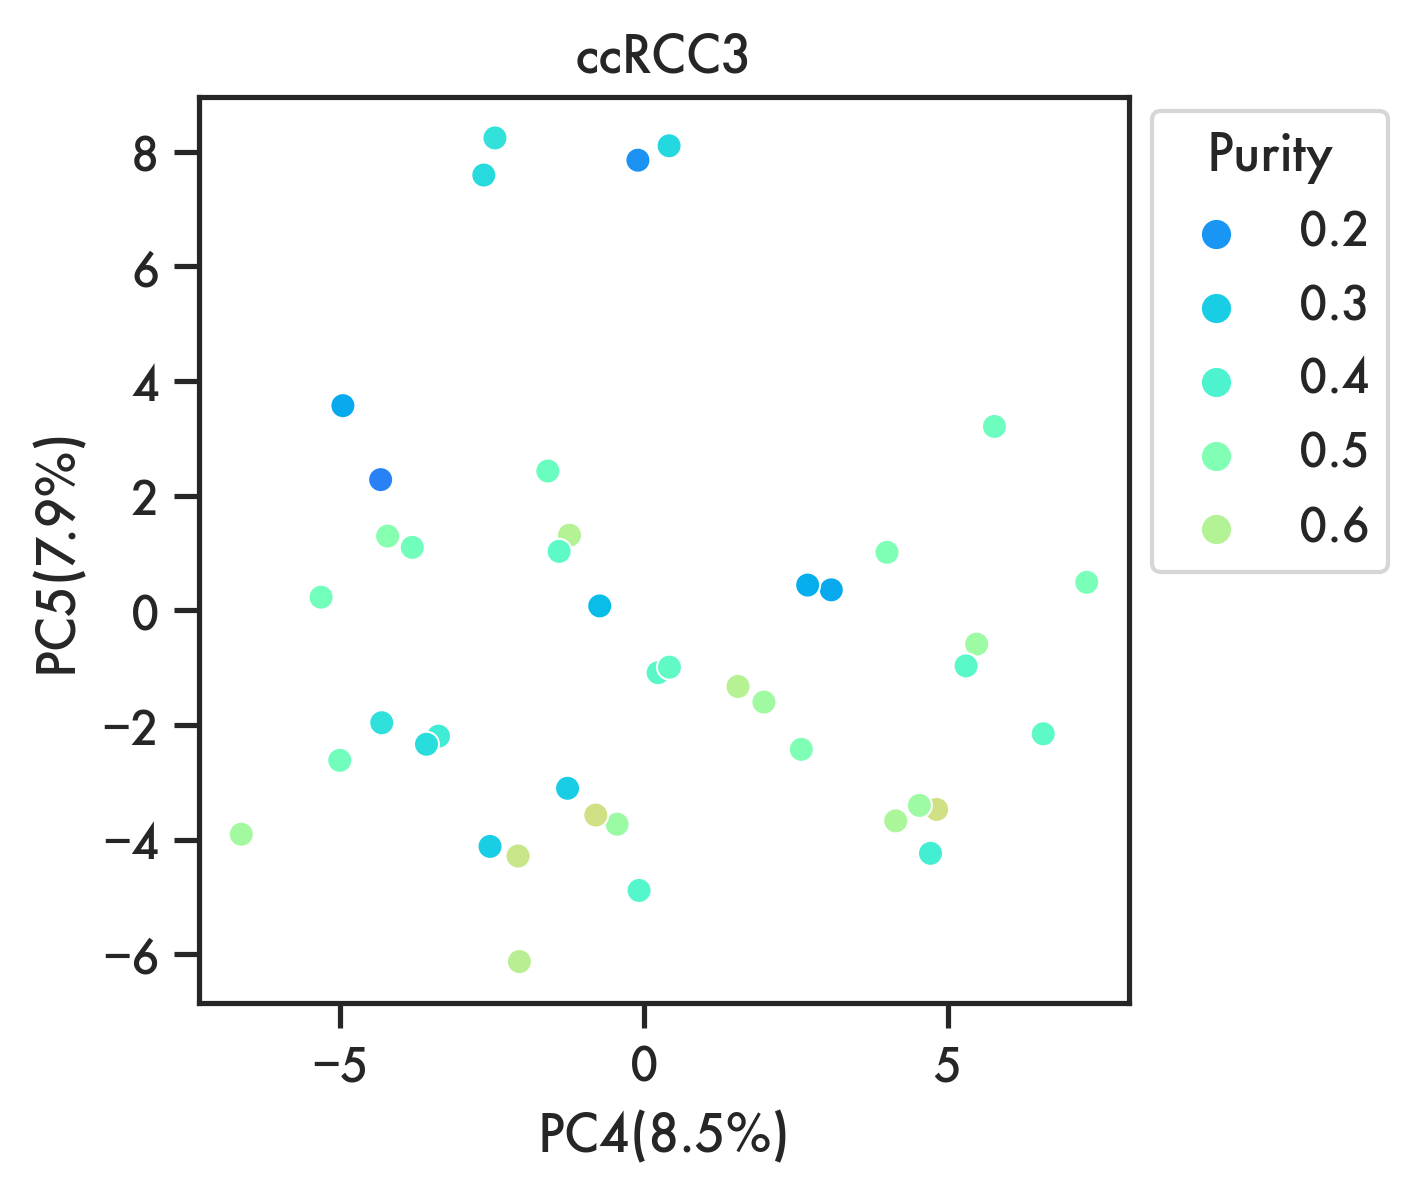

In [28]:
cancer_code = "ccRCC3"
metabolism_data = pd.read_csv("../Data/Generated Data/Tumor Generated/processed_%s_metabolite_data.csv"%cancer_code)
#metabolism_data = metabolism_data.set_index("Unnamed: 0")
meta_data = pd.read_csv("../Data/Tumour Data/TUMOR.PURITY.csv", index_col = "Unnamed: 0")
meta_data.index = [x.replace(".","-") for x in meta_data.index]

metabolism_data = metabolism_data[~metabolism_data.index.isin(necrosis_samples)]
list_of_cell_lines = list(set(metabolism_data.index).intersection(set(meta_data.index)))
meta_data = meta_data.loc[list_of_cell_lines]
from sklearn.decomposition import PCA
model = PCA(n_components=10)            # 2. Instantiate the model with hyperparameters
model.fit(metabolism_data)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(metabolism_data)
explained_variance = model.explained_variance_ratio_
sns.set_theme(style = "ticks", rc={'figure.figsize':(4,4),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
for x in range(0,5):
    metabolism_data["PC"+ str(x+1)] = X_2D[:, x]
metabolism_data = metabolism_data.loc[list_of_cell_lines]
metabolism_data["Purity"] = meta_data["PURITY"].astype(float)
fig,axpca = plt.subplots()
first_pc = "PC4"
second_pc = "PC5"
scatter = sns.scatterplot(x = first_pc, y = second_pc, data=metabolism_data, palette= "rainbow",hue = "Purity", hue_norm = (0,1.0), sizes= 1)
scatter.set(title = cancer_code)
axpca.set(xlabel=first_pc+'({}%)'.format(round(explained_variance[1]*100, 1)), ylabel=second_pc+'({}%)'.format(round(explained_variance[2]*100, 1)))
sns.move_legend(axpca,"upper left", bbox_to_anchor=(1, 1.01))

Spearman correlation for Purity along PC1-5

In [27]:
from scipy.stats import spearmanr
matrix = pd.DataFrame(columns = ["R-value","p-value", "Covariate"])
for i in range(1,6):
        rho, p = spearmanr(metabolism_data["PC%i" %i], metabolism_data["Purity"].astype(float))
        print(rho, p)
        matrix.loc["%i"%i]= [rho,p,"Purity"]
matrix

0.11009174319772803 0.4821880629118662
-0.16355193125259185 0.29465899428241654
0.23181183238479083 0.13471668144819332
0.18650658827049948 0.2311082626539798
-0.41507154482709946 0.005645723544943954


,R-value,p-value,Covariate
1,0.110092,0.482188,Purity
2,-0.163552,0.294659,Purity
3,0.231812,0.134717,Purity
4,0.186507,0.231108,Purity
5,-0.415072,0.005646,Purity
